#### Train a Multilayer Perceptron model with ApacheJIT dataset.

#### Import libraries.

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import tensorflow as tf
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from tensorflow import keras


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### Load dataset.

In [2]:

df = None

dtypes = {"commit_id": "str", "project" : "str", "buggy" : "str", "fix" : "str", "year" : "str", "author_date" : "str",
          "la" : "int16", "ld" : "int16", "nf" : "int16", "nd" : "int16", "ns" : "int16", "ent" : "float64",
          "ndev" : "float64", "age" : "float64", "nuc" : "float64", "aexp" : "int16", "arexp" : "float64", "asexp" : "float64"}

try:
    print("\nStart loading CSV file...")
    df = pd.read_csv("../dataset/java/apachejit_total.csv", sep = ",", dtype = dtypes)
    print("\nFinish loading CSV file...")
except Exception as e:
    print("\nFail to load CSV file.")
    print("Error: {}".format(e))



Start loading CSV file...

Finish loading CSV file...


#### Check for dataset shape.

In [3]:

df.shape


(106674, 18)

#### Remove unnecessary features from the dataset and show class identification.

In [4]:

df.drop(columns = ["commit_id", "project", "fix", "year", "author_date"], inplace = True)
le = LabelEncoder()
df.loc[:, ["buggy"]] = le.fit_transform(df["buggy"])
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"Dataset classes: {mapping}")


Dataset classes: {'False': 0, 'True': 1}


#### Create a helper function to train a Multilayer Perceptron model.

In [5]:

def train_mlp_model(mlp_model, X_train, y_train, X_test, y_test, num_epochs, batch_size, validation_split, model_cfg_file):
    """
    Train a Neural Network model.
    Parameters:
        mlp_model (Sequential): model to be trained.
        X_train (np.array): array of features values.
        X_test (np.array): array of features values.
        y_train (np.array): array of target values.
        y_test (np.array): array of target values.
        num_epochs (int): number of epochs of training.
        batch_size (int): batch size.
        validation_split (float): percentage of instances for validation set.
        model_cfg_file (str): file to save the configuration model.
    Returns:
        history (History object): history of training metrics.
    """
    start_time = time.time()
    print("\nStarting training at: ", time.strftime("%H:%M:%S", time.localtime()))
    es = EarlyStopping(monitor = "loss", mode = "min", verbose = 1, patience = 100)
    history = mlp_model.fit(X_train, y_train, validation_split = validation_split, epochs = num_epochs, batch_size = batch_size, 
                            verbose = 1, callbacks = [es])
    mlp_model.save("../modelconfig/apachejit/" + model_cfg_file)
    _, train_accuracy = mlp_model.evaluate(X_train, y_train, verbose = 0)
    _, test_accuracy = mlp_model.evaluate(X_test, y_test, verbose = 0)
    elapsed_seconds = time.time() - start_time
    print("\nTime taken for training: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_seconds)))
    print("\nTrain Accuracy: {:.2f} %".format(train_accuracy * 100))
    print("Test Accuracy: {:.2f} %".format(test_accuracy * 100))
    print("\nEvaluate detailed metrics:")
    pred_classes = np.argmax(mlp_model.predict(X_test), axis = 1)
    truth_classes = y_test
    print(classification_report(truth_classes, pred_classes, zero_division = 0))
    ConfusionMatrixDisplay.from_predictions(truth_classes, pred_classes)
    return history


#### Create helper functions to instantiate Multilayer Perceptron models.

In [6]:

def create_baseline():
    act_fuction = "relu"
    k_init = "he_normal"
    model = Sequential()
    model.add(Dense(64, input_dim = 12, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(64, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(64, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(2, activation = "softmax"))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model

def create_v1():
    act_fuction = "relu"
    k_init = "he_normal"
    model = Sequential()
    model.add(Dense(256, input_dim = 12, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(256, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(256, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(2, activation = 'softmax'))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model

def create_v2():
    act_fuction = "relu"
    k_init = "he_normal"
    model = Sequential()
    model.add(Dense(512, input_dim = 12, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(2048, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(512, activation = act_fuction, kernel_initializer = k_init))
    model.add(Dense(2, activation = 'softmax'))
    opt = Adam(learning_rate = 0.001)
    model.summary()
    model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    return model


#### Perform oversampling of the dataset samples and split dataset samples.

In [7]:

feature_names = ["la", "ld", "nf", "nd", "ns", "ent", "ndev", "age", "nuc", "aexp", "arexp", "asexp"]
X = df.loc[:, feature_names].values
y = df.loc[:, ["buggy"]].values.astype(int)

transformer = RobustScaler().fit(X)
X_rbs = transformer.transform(X)

print("\nStart generating SMOTE...")
sm = SMOTE(random_state = 42)
X_array_res, y_array_res = sm.fit_resample(X_rbs, y)
print("{} samples after SMOTE.".format(len(y_array_res)))
print("Finish generating SMOTE.")
print(f"Class distribution after SMOTE: {Counter(y_array_res)}")

X_train, X_test, y_train, y_test = train_test_split(X_array_res, y_array_res, test_size = 0.2, stratify = y_array_res, random_state = 42)
print("Number of samples for training: {}".format(len(X_train)))
print("Number of samples for test: {}".format(len(X_test)))



Start generating SMOTE...
156870 samples after SMOTE.
Finish generating SMOTE.
Class distribution after SMOTE: Counter({0: 78435, 1: 78435})
Number of samples for training: 125496
Number of samples for test: 31374


#### Train baseline version of Multilayer Perceptron.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 9,282
Trainable params: 9,282
Non-trainable params: 0
_________________________________________________________________

Starting training at:  08:21:14
Epoch 1/500
3530/3530 [==============================] - 16s 4ms/step - loss: 0.5950 - accuracy: 0.7043 - val_loss: 0.5568 - val_accuracy: 0.7186
Epoch 2

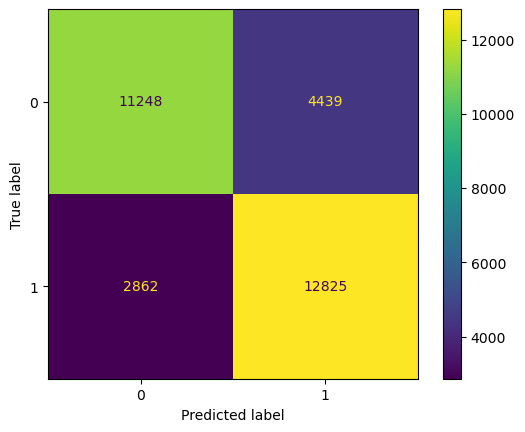

In [9]:

bs_model = create_baseline()
bs_num_epochs = 500
bs_batch_size = 32
bs_valid_split = 0.1

training_history = train_mlp_model(bs_model, X_train, y_train, X_test, y_test, bs_num_epochs, bs_batch_size, bs_valid_split, "baseline_model.h5")


#### Train version 1 of Multilayer Perceptron.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               3328      
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 135,426
Trainable params: 135,426
Non-trainable params: 0
_________________________________________________________________

Starting training at:  13:55:20
Epoch 1/500
3530/3530 [==============================] - 12s 3ms/step - loss: 0.5987 - accuracy: 0.7040 - val_loss: 0.5599 - val_accuracy: 0.7177
E

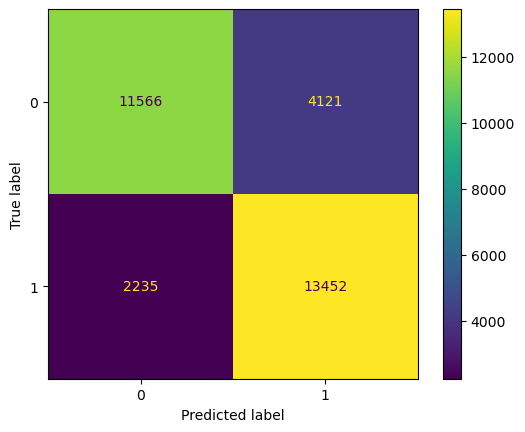

In [10]:

v1_model = create_v1()
v1_num_epochs = 500
v1_batch_size = 32
v1_valid_split = 0.1

training_history_v1 = train_mlp_model(v1_model, X_train, y_train, X_test, y_test, v1_num_epochs, v1_batch_size, v1_valid_split, "v1_model.h5")


#### Train version 2 of Multilayer Perceptron.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               6656      
                                                                 
 dense_1 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,107,394
Trainable params: 2,107,394
Non-trainable params: 0
_________________________________________________________________

Starting training at:  21:10:30
Epoch 1/500
3530/3530 [==============================] - 21s 5ms/step - loss: 0.6235 - accuracy: 0.7034 - val_loss: 0.5651 - val_accuracy: 0.7169

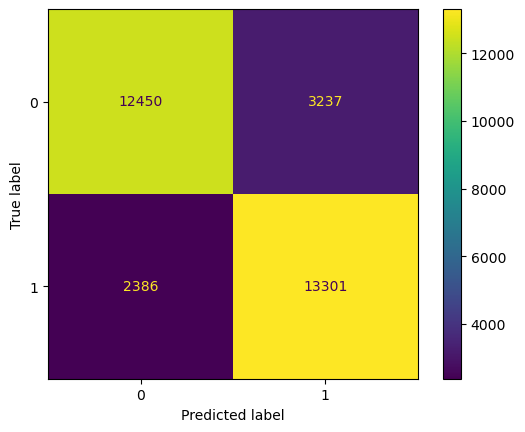

In [8]:

v2_model = create_v2()
v2_num_epochs = 500
v2_batch_size = 32
v2_valid_split = 0.1

training_history_v2 = train_mlp_model(v2_model, X_train, y_train, X_test, y_test, v2_num_epochs, v2_batch_size, v2_valid_split, "v2_model.h5")


#### Show training accuracy history.

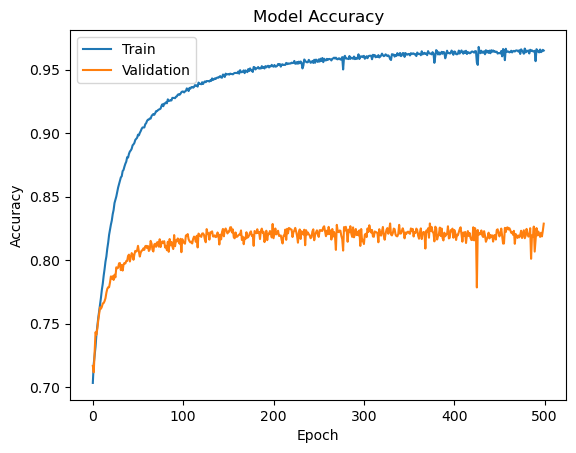

In [9]:

plt.plot(training_history_v2.history["accuracy"])
plt.plot(training_history_v2.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()


#### Show training loss history.

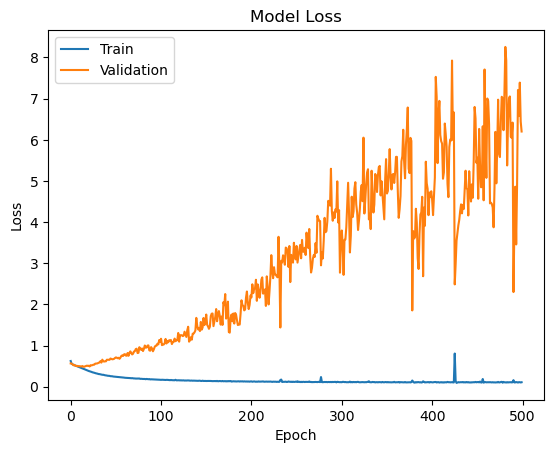

In [10]:

plt.plot(training_history_v2.history["loss"])
plt.plot(training_history_v2.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc = "upper left")
plt.show()


#### Show SHAP analysis.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


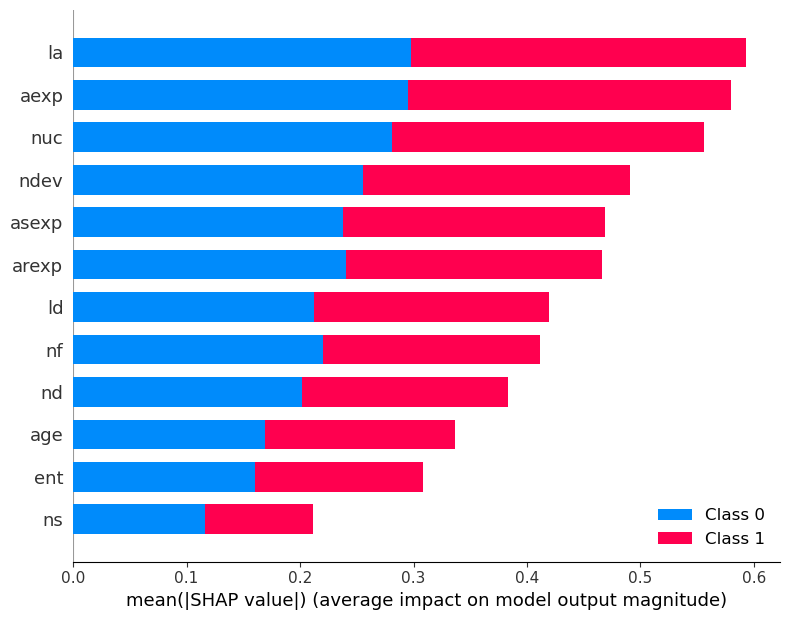

In [8]:

# Load model config.
reloaded_model = load_model("../modelconfig/apachejit/v2_model.h5")
# Calculate shap values and plot results.
shap.initjs()
explainer = shap.DeepExplainer(reloaded_model, X_train[0:15687])
shap_values = explainer.shap_values(X_test[0:31374])
shap.summary_plot(shap_values, X_test[0:31374], plot_type = "bar", feature_names = feature_names)
